In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
import joblib
import numpy as np

# Load dataset
df = pd.read_csv('Cleaned_KL_Housing_Dataset.csv')

# Separate features and target variable
X = df.drop('Price', axis=1)
y = df['Price']

# One-hot encode categorical features
X = pd.get_dummies(X)

# Log transformation of the target variable to reduce skewness
y = np.log1p(y)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Align the train and test data
X_train, X_test = X_train.align(X_test, join='left', axis=1, fill_value=0)

# Feature engineering: Adding interaction terms or polynomial features (optional)
# Example: X_train['Sqft_Rooms'] = X_train['Sqft'] * X_train['Rooms']
# Example: X_test['Sqft_Rooms'] = X_test['Sqft'] * X_test['Rooms']

# Hyperparameter tuning using Grid Search
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2']
}

grid_search = GridSearchCV(estimator=RandomForestRegressor(), param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

# Best parameters from Grid Search
best_params = grid_search.best_params_
print(f'Best Parameters: {best_params}')

# Train the model with best parameters
best_rf = RandomForestRegressor(**best_params)
best_rf.fit(X_train, y_train)

# Save the trained model
joblib.dump(best_rf, 'best_rf_model.pkl')

# Evaluate the model
y_pred = best_rf.predict(X_test)

# Inverse the log transformation
y_test_exp = np.expm1(y_test)
y_pred_exp = np.expm1(y_pred)

mse = mean_squared_error(y_test_exp, y_pred_exp)
mae = mean_absolute_error(y_test_exp, y_pred_exp)
score = best_rf.score(X_test, y_test)

print(f'Model Score: {score}')
print(f'Mean Squared Error: {mse}')
print(f'Mean Absolute Error: {mae}')


Fitting 5 folds for each of 324 candidates, totalling 1620 fits


C:\Users\Acer\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py:540: FitFailedWarning: 
540 fits failed out of a total of 1620.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
213 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\Acer\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Acer\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\base.py", line 1466, in wrapper
    estimator._validate_params()
  File "C:\Users\Acer\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\base.py", l

Best Parameters: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Model Score: 0.9079542789635241
Mean Squared Error: 0.17156790085801318
Mean Absolute Error: 0.19120308173152456


In [3]:
# Verification of Model Accuracy on Training Data
train_pred = best_rf.predict(X_train)
train_pred_exp = np.expm1(train_pred)
y_train_exp = np.expm1(y_train)

train_mse = mean_squared_error(y_train_exp, train_pred_exp)
train_mae = mean_absolute_error(y_train_exp, train_pred_exp)
train_score = best_rf.score(X_train, y_train)

print(f'Training Data Model Score: {train_score}')
print(f'Training Data Mean Squared Error: {train_mse}')
print(f'Training Data Mean Absolute Error: {train_mae}')

# Testing on Unseen Data
unseen_data = {
    'Location': ['KLCC'],
    'Rooms': [4],
    'Bathrooms': [4],
    'Car Parks': [2],
    'Property Type': ['Serviced Residence'],
    'Furnishing': ['Fully Furnished'],
    'Build Type': ['Built-up'],
    'Sqft': [1378]
}
unseen_df = pd.DataFrame(unseen_data)

# One-hot encode categorical features
unseen_df = pd.get_dummies(unseen_df)

# Ensure the unseen data has the same columns as the training data
missing_cols_unseen = set(best_rf.feature_names_in_) - set(unseen_df.columns)
for col in missing_cols_unseen:
    unseen_df[col] = 0
unseen_df = unseen_df[best_rf.feature_names_in_]

# Make predictions on unseen data
unseen_pred_log = best_rf.predict(unseen_df)
unseen_pred = np.expm1(unseen_pred_log)

print("Predicted Price for Unseen Data:", unseen_pred[0])


Training Data Model Score: 0.9837547311030098
Training Data Mean Squared Error: 0.03616167857074152
Training Data Mean Absolute Error: 0.08972044757546303
Predicted Price for Unseen Data: 1.2954384959205845


C:\Users\Acer\AppData\Local\Temp\ipykernel_1268\633473956.py:33: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  unseen_df[col] = 0
C:\Users\Acer\AppData\Local\Temp\ipykernel_1268\633473956.py:33: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  unseen_df[col] = 0
C:\Users\Acer\AppData\Local\Temp\ipykernel_1268\633473956.py:33: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) i

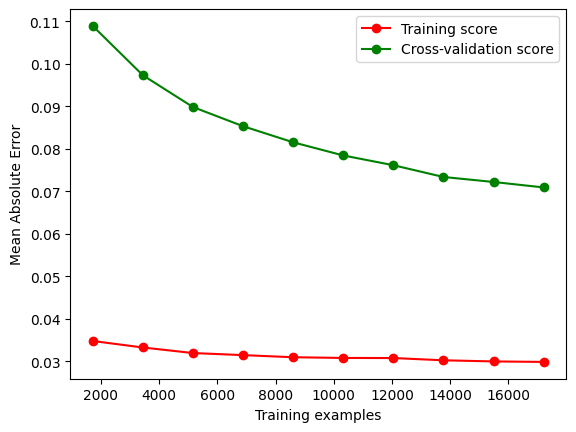

In [4]:
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve

train_sizes, train_scores, val_scores = learning_curve(best_rf, X, y, cv=5, scoring='neg_mean_absolute_error', train_sizes=np.linspace(0.1, 1.0, 10))

train_scores_mean = -train_scores.mean(axis=1)
val_scores_mean = -val_scores.mean(axis=1)

plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
plt.plot(train_sizes, val_scores_mean, 'o-', color="g", label="Cross-validation score")

plt.xlabel("Training examples")
plt.ylabel("Mean Absolute Error")
plt.legend(loc="best")
plt.show()

